In [ ]:
# setup Colabs
!pip install brian2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


In [1]:
from brian2 import *
#import brian2cuda
import matplotlib.pyplot as plt
import time

In [28]:
class StructuralPlasticityModel:
    def __init__(self,
                dt = 0.1*ms,
                N_E = 100,
                N_I = 25,
                V_th = 20*mV,
                V_res = 10*mV,
                t_ref = 2*ms,
                tau_m = 50*ms,
                nu_ext = 15*Hz,
                J = 0.1*mV,
                g = 8,
                delay = 1.5*ms,
                tau_ca = 10*second,
                delta_T_s = 100*ms,
                nu = 8*Hz,
                beta_d = 2,
                beta_a = 2):

        start_scope()

        self.network = Network()

        # Neurons
        self.N_E = N_E
        self.N_I = N_I 
        self.V_th = V_th
        self.V_res = V_res
        self.t_ref = t_ref
        self.tau_m = tau_m

        # Background Input
        self.nu_ext = nu_ext
        # Synapses
        self.J = J
        self.g = g
        self.J_I = - J * g
        self.delay = delay

        # Plasticity
        self.tau_ca = tau_ca
        self.delta_T_s = delta_T_s
        self.nu = nu
        self.beta_d = beta_d
        self.beta_a = beta_a

        inh_eqs = '''
        dV/dt = - V / tau_m : volt (unless refractory)
        '''
        exc_eqs = '''
        dV/dt = - V / tau_m : volt (unless refractory)
        dphi/dt = - phi / tau_ca : Hz
        dd/dt = (nu - phi)/beta_d : 1
        da/dt = (nu - phi)/beta_a : 1
        '''

        self.namespace = {'tau_m': self.tau_m, 'tau_ca': self.tau_ca, 'nu': self.nu, 'beta_d': self.beta_d, 'beta_a': self.beta_a, 'J': self.J, 'J_I': self.J_I, 'tau_m': self.tau_m, 'V_th': self.V_th, 'V_res': self.V_res, 't_ref': self.t_ref, 'nu_ext': self.nu_ext, 'delay': self.delay}

        
        # Create Neurons
        self.E = NeuronGroup(self.N_E, exc_eqs, threshold='V>V_th', reset='V=V_res\nphi+=1*Hz', refractory=self.t_ref)
        #\nphi+=1/tau_ca
        self.I = NeuronGroup(self.N_I, inh_eqs, threshold='V>V_th', reset='V=V_res', refractory=self.t_ref)
        
        # Background Input
        # #(tau_m/ms)*
        self.P_E = PoissonInput(self.E, 'V', 1, self.nu_ext, (tau_m/ms)*J)
        self.P_I = PoissonInput(self.I, 'V', 1, self.nu_ext, (tau_m/ms)*J)

        self.network.add(self.E, self.I, self.P_E, self.P_I)
        
        # Static Synapses
        self.S_I_I = Synapses(self.I, self.I, on_pre='V_post += (tau_m/ms)*J_I', delay=self.delay, name='S_I_I')
        self.S_I_I.connect(p=0.1/N_I)
        
        self.S_I_E = Synapses(self.I, self.E, on_pre='V_post += (tau_m/ms)*J_I', delay=self.delay, name='S_I_E')
        self.S_I_E.connect(p=0.1/N_E)
        
        self.S_E_I = Synapses(self.E, self.I, on_pre='V_post += (tau_m/ms)*J', delay=self.delay, name='S_E_I')
        self.S_E_I.connect(p=0.1/N_I)
        
        # Dynamic synapses
        self.S_E_E = Synapses(self.E, self.E, model='''
        c : 1
        '''
        ,on_pre='V_post += c*(tau_m/ms)*J', delay=self.delay, name='S_E_E')
        self.S_E_E.connect()
        
        self.C_E = []
        self.C_E_t = []
        self.M = SpikeMonitor(self.E)
        self.M2 = StateMonitor(self.E, 'V', record=True)
        self.M3 = StateMonitor(self.S_E_E, 'c', record=[0])

        self.structural_plasticity = network_operation(dt=self.delta_T_s)(self.rewiring)

        self.network.add(self.S_I_I, self.S_I_E, self.S_E_I, self.S_E_E, self.M, self.M2, self.M3, self.structural_plasticity)
        self.network.add(self.S_I_I, self.S_I_E, self.S_E_I, self.S_E_E, self.M, self.M2, self.M3)

    def run(self, duration):
        self.network.run(duration, namespace=self.namespace, report='text', report_period=20*second)
    
    def delete_connections_post(self, delta_a, delta_d):
        gen = np.random.default_rng()
        for i, d_a in enumerate(delta_a):
            if(d_a < 0):
                # sample deleted connections without replacement
                delta_Ci = gen.multivariate_hypergeometric(self.S_E_E.c[i, :].astype(int).flatten(), np.clip(-d_a, 0, sum(self.S_E_E.c[i, :].astype(int))))
                # update connectivity matrix and free dentritic elements
                self.S_E_E.c[i, :] -= delta_Ci
                # TODO: Maybe this should be done after rewiring, to delay to next timestep
                delta_d += delta_Ci
        return delta_a, delta_d 
    
    def delete_connections_pre(self, delta_a, delta_d):
        gen = np.random.default_rng()
        for i, d_d in enumerate(delta_d):
            if(d_d < 0):
                # sample deleted connections without replacement
                delta_Ci = gen.multivariate_hypergeometric(self.S_E_E.c[:, i].astype(int).flatten(), np.clip(-d_d, 0, sum(self.S_E_E.c[:, i].astype(int))))
                # update connectivity matrix and free axonal elements
                self.S_E_E.c[:, i] -= delta_Ci
                # TODO: Maybe this should be done after rewiring, to delay to next timestep
                delta_a += delta_Ci
        return delta_a, delta_d

    def create_connections(self, delta_a, delta_d):
        # Calculate number of new connections
        a_free = np.floor(delta_a).clip(0).astype(int)
        d_free = np.floor(delta_d).clip(0).astype(int)
        a_tot = np.sum(a_free)
        d_tot = np.sum(d_free)
        num_connections = min(a_tot, d_tot)
    
        # TODO: Choose random connections -> hypergeometric distribution
        a_free = np.repeat(range(0, self.N_E), a_free)
        a_free = np.random.choice(a_free, num_connections, replace=False)
        d_free = np.repeat(range(0, self.N_E), d_free)
        d_free = np.random.choice(d_free, num_connections, replace=False)
    
        # Make array of tuples of chosen connections
        chosen_connections = np.column_stack((a_free, d_free))
    
        # count duplicates
        chosen_connections, counts = np.unique(chosen_connections, axis=0, return_counts=True)
    
        # Increase weight of chosen connections
    
        # TODO: This loop should be vectorized
    
        for i in range(len(chosen_connections)):
            self.S_E_E.c[chosen_connections[i][0],chosen_connections[i][1]] += counts[i]
    
    def rewiring(self, t):
        # Calculate the number of new/deleted connections for each neuron
        print('Rewiring at t = ', t/ms)

        tmp_time = time.time()
        delta_a = (np.floor(self.E.a) - np.sum(self.S_E_E.c[:,:].reshape(self.N_E, self.N_E), axis=1)).astype(int)
        delta_d = (np.floor(self.E.d) - np.sum(self.S_E_E.c[:,:].reshape(self.N_E, self.N_E), axis=1)).astype(int)
        print('Time for calculating delta_a and delta_d: ', time.time() - tmp_time)
        tmp_time = time.time()

        delta_a, delta_d = self.delete_connections_pre(delta_a, delta_d)
        print('Time for deleting connections: ', time.time() - tmp_time)
        tmp_time = time.time()
        delta_a, delta_d = self.delete_connections_post(delta_a, delta_d)
        print('Time for deleting connections: ', time.time() - tmp_time)
        tmp_time = time.time()
        self.create_connections(delta_a, delta_d)
        print('Time for creating connections: ', time.time() - tmp_time)

        self.C_E_t.append(t/ms)
        self.C_E.append(np.sum(self.S_E_E.c[:,:])/self.N_E**2)

    def plot(self):
        plt.plot(self.M.t/ms, self.M.i, '.k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron index')
        plt.show()

        plt.plot(self.M2.t/ms, self.M2.V[0]/mV)
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane potential (mV)')
        plt.show()

        plt.plot(self.M3.t/ms, self.M3.c[0])
        plt.xlabel('Time (ms)')
        plt.ylabel('Synaptic weight')
        plt.show()

        plt.plot(self.C_E_t, self.C_E)
        plt.xlabel('Time (ms)')
        plt.ylabel('Average synaptic weight')


    


In [39]:
model = StructuralPlasticityModel()
model.run(10*second)

INFO       No numerical integration method specified for group 'neurongroup_8', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_9', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 10. s
Rewiring at t =  0.0


KeyboardInterrupt: 

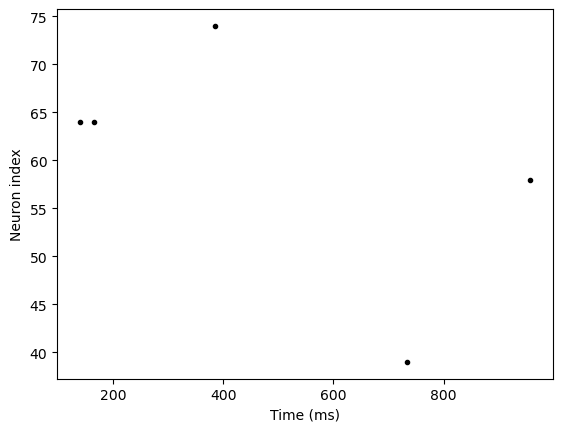

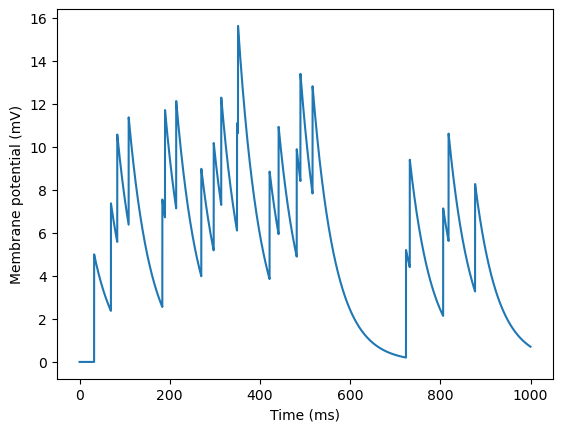

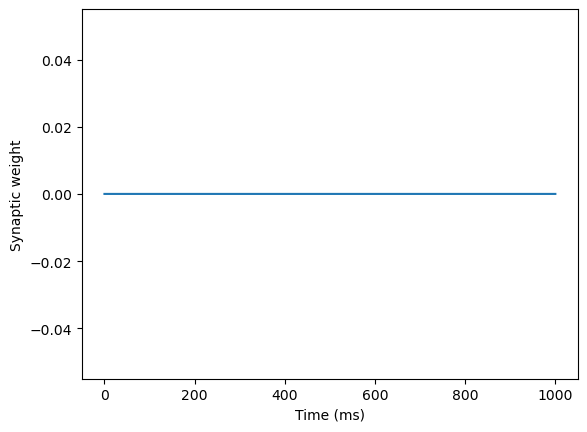

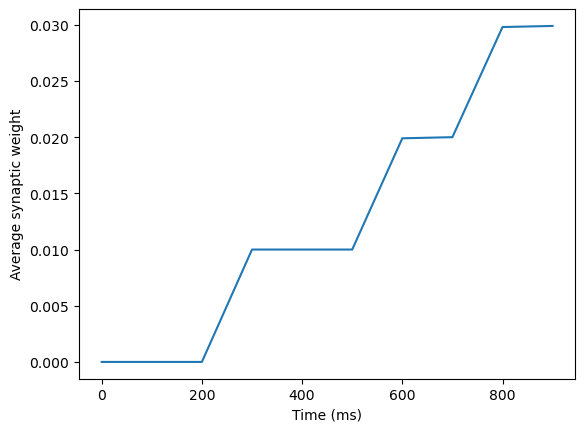

In [28]:
model.plot()

In [29]:
model = StructuralPlasticityModel(N_E=300, N_I=75)

In [19]:
#create a connectivity matrix dummy with random values between 0 and 3 5x5 
#c = np.random.randint(0, 3, size=(model.N_E, model.N_E))
# create a a and d dummy with random values between 0 and 3 5x1
a = np.random.randint(0, 17, size=(model.N_E)).astype(int)
d = np.random.randint(0, 17, size=(model.N_E)).astype(int)


In [30]:
#print("before")
model.E.a = a
model.E.d = d
#print("Connectivity\n", model.S_E_E.c[:,:].reshape(model.N_E, model.N_E), "Axonal Elements\n", model.E.a, "Dentritic Elements\n", model.E.d)
model.rewiring(0*ms)
#print("after")
#print("Connectivity\n", model.S_E_E.c[:,:].reshape(model.N_E, model.N_E), "Axonal Elements\n", model.E.a, "Dentritic Elements\n", model.E.d)


Rewiring at t =  0.0
Time for calculating delta_a and delta_d:  0.18844294548034668
Time for deleting connections:  0.00018167495727539062
Time for deleting connections:  9.179115295410156e-05
Time for creating connections:  1.8782715797424316


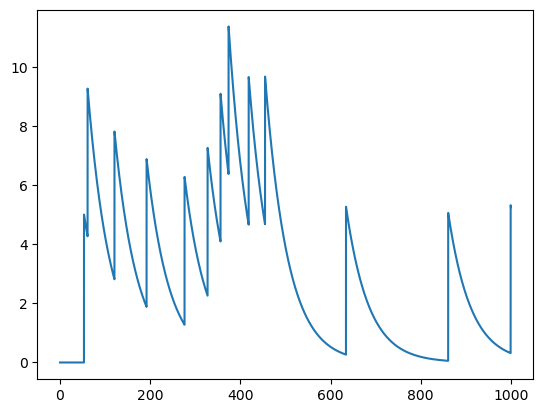

In [130]:
plot(model.M2.t/ms, model.M2.V[0]/mV)

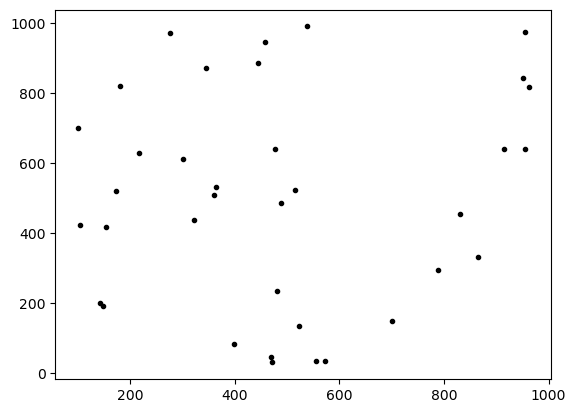

In [131]:
start = 500
end = 1000
plot(model.M.t/ms, model.M.i, '.k')

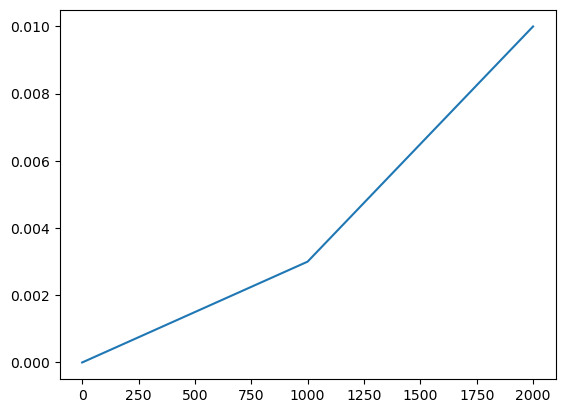

In [5]:
plot(C_E_t, C_E)

<synapses.N: 2>
<synapses_1.N: 4>
<synapses_2.N: 6>


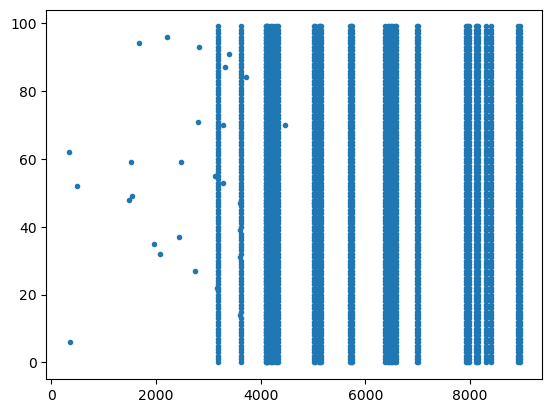

In [6]:
plot(M.t/ms, M.i, '.')
print(S_I_I.N)
print(S_I_E.N)
print(S_E_I.N)